In [18]:
GPT3 = False
import pandas as pd
df = pd.read_json("eval_xnprompt_yeffect_count.jsonl", lines=True)
df['model'].unique()


array(['T5-Small (Count)', 'T5-Large (Count)', 'T5-3B (Count)',
       'T5-11B (Count)'], dtype=object)

In [19]:
if GPT3:
    p_to_remove = ['P155']
else:
    p_to_remove = []

columns = list(set(df.columns.to_list()) - set(p_to_remove))
p_columns = [col for col in columns if col.startswith('P')]

def sum_n_corrects(row):
    sum = 0
    for col in p_columns:
        sum += row[col]
    return sum

df = df[columns]
df['sum'] = df.apply(sum_n_corrects, axis=1)
print(df)
df = df[['nprompt', 'sum', 'model']]

gb = df.groupby(['model', 'nprompt']).count().reset_index()
onerow = gb.loc[gb['sum']==1].to_dict(orient='records')

rows = [df.loc[(df['model']==args['model']) & (df['nprompt']==args['nprompt'])].iloc[0] for args in onerow]
pd.DataFrame(rows*4)
df = pd.concat([df, pd.DataFrame(rows*4)])



     P740  P1366  P50  P37  P155             model  P27  P641  P495  P140  \
0       2      3    0   76    12  T5-Small (Count)    5     4    58    10   
1       3      1    0   78    11  T5-Small (Count)    1     3    66    13   
2       4      2    0   71    11  T5-Small (Count)    5     7    73    11   
3       4      2    0   70    10  T5-Small (Count)    7     7    62     9   
4       1      2    0   70    13  T5-Small (Count)    4     6    58    11   
..    ...    ...  ...  ...   ...               ...  ...   ...   ...   ...   
563    48     48    7  323    24    T5-11B (Count)    4   142   194    49   
564    49     46    7  327    18    T5-11B (Count)    3   135   193    50   
565    51     48    7  328    27    T5-11B (Count)    3   130   196    50   
566    51     49    7  324    22    T5-11B (Count)    4   134   198    48   
567    51     48    7  324    21    T5-11B (Count)    2   131   194    47   

     ...  P131  P937  P119  P36  P1412  P30  P69  P159  P103   sum  
0    .

In [15]:
# df['total'] = 
def get_relative_effect_table(group):
    without_tta = group[group["nprompt"] == 1].iloc[0]['sum']
    group['sum'] /= without_tta
    return group

relative_effect = df.groupby("model").apply(get_relative_effect_table)

In [16]:
relative_effect = relative_effect.reset_index(drop=True).rename(columns={'sum': 'relative_effect'})

     nprompt  relative_effect             model
0          1         1.000000    T5-11B (Count)
1          2         0.944865    T5-11B (Count)
2          2         0.940901    T5-11B (Count)
3          2         0.939099    T5-11B (Count)
4          2         0.942703    T5-11B (Count)
..       ...              ...               ...
595       30         1.443820  T5-Small (Count)
596        1         1.000000  T5-Small (Count)
597       30         1.443820  T5-Small (Count)
598        1         1.000000  T5-Small (Count)
599       30         1.443820  T5-Small (Count)

[600 rows x 3 columns]


Text(0, 0.5, 'Relative effect')

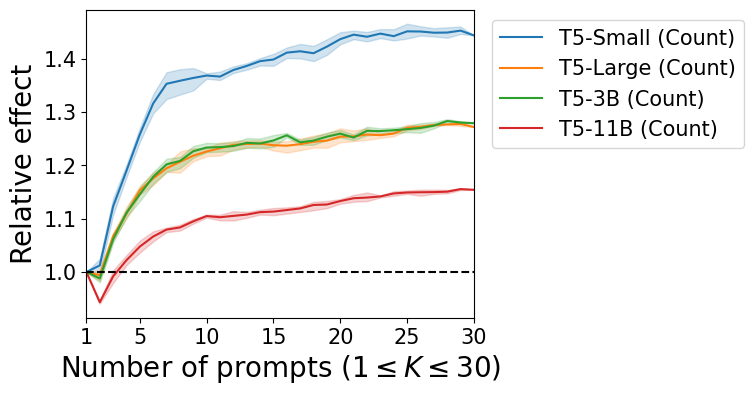

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

rename_dict = {
    't5-small': 'T5-Small',
    't5-large': 'T5-Large',
    't5-3b': 'T5-3B',
    't5-11b': 'T5-11B',
    't5-small-gpt3': 'T5-Small (GPT3)',
    't5-large-gpt3': 'T5-Large (GPT3)',
    't5-3b-gpt3': 'T5-3B (GPT3)',
    't5-11b-gpt3': 'T5-11B (GPT3)',
    'flan-small': 'FLAN-T5-Small',
    'flan-xl': 'FLAN-T5-XL',
    't0_3b': 'T0_3B',
    'T5-Small (Count)': 'T5-Small (Count)',
    'T5-Large (Count)': 'T5-Large (Count)',
    'T5-3B (Count)': 'T5-3B (Count)',
    'T5-11B (Count)': 'T5-11B (Count)',
}
relative_effect['model'] = relative_effect['model'].map(rename_dict)
if GPT3:
    graph_df = relative_effect.loc[relative_effect['nprompt'] <= 11]
    graph_df_before = graph_df.loc[graph_df['model'].isin(['T5-Small', 'T5-Large', 'T5-3B', 'T5-11B'])]
    graph_df = graph_df.loc[graph_df['model'].isin([ 'T5-Small (GPT3)', 'T5-Large (GPT3)', 'T5-3B (GPT3)', 'T5-11B (GPT3)'])]
    MAX_PROMPTS = 11
else:
    # graph_df = relative_effect.loc[relative_effect['model'].isin(['T5-Small', 'T5-Large', 'T5-3B', 'T5-11B', 'FLAN-T5-Small', 'FLAN-T5-XL', 'T0_3B'])]
    graph_df = relative_effect.loc[relative_effect['model'].isin(['T5-Small (Count)', 'T5-Large (Count)', 'T5-3B (Count)', 'T5-11B (Count)'])]
    MAX_PROMPTS = 30

print(graph_df)

graph = sns.lineplot(
    data=graph_df.sort_index(ascending=False),
    x="nprompt",
    y="relative_effect",
    orient="x",
    hue="model",
    )

if GPT3:
    graph = sns.lineplot(
        data=graph_df_before.sort_index(ascending=False),
        x="nprompt",
        y="relative_effect",
        orient="x",
        hue="model",
        alpha=0.2,
        )
graph.axhline(1.00, ls='--', color='black')
graph.figure.set_size_inches(5, 4)
graph.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=15)

graph.set_xlabel(fr'Number of prompts ($1\leq K\leq {MAX_PROMPTS}$)', fontsize=20)

if GPT3:
    graph.set_xlim(1, MAX_PROMPTS)
    xticks = list(range(1, MAX_PROMPTS+2, 2))
    graph.set_xticks(xticks)
    graph.tick_params(labelsize=15)
else:
    graph.set_xlim(1, MAX_PROMPTS)
    xticks = graph.get_xticks()
    xticks[0] = 1
    graph.set_xticks(xticks)
    graph.tick_params(labelsize=15)

graph.set_ylabel(r'Relative effect', fontsize=20)


In [129]:
graph.figure.savefig(f'eval_xnprompt_yeffect{"_gpt3" if GPT3 else ""}.pdf', bbox_inches="tight")